In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 加载图像并将其转换为灰度图像
img = cv2.imread('./2-2.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 高斯滤波降噪
gaussian_img = cv2.GaussianBlur(gray, (7, 7), 0)

# 边缘检测
edges = cv2.Canny(gaussian_img, 50, 150)

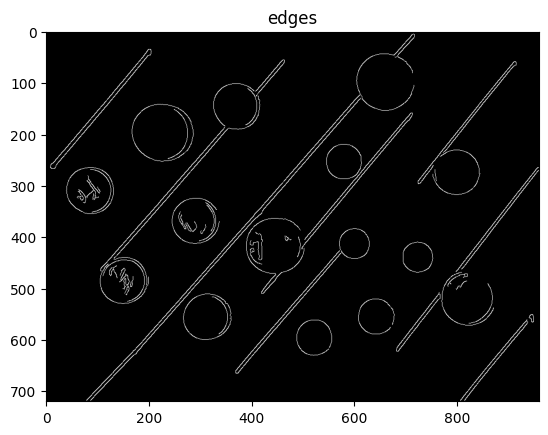

In [3]:
plt.imshow(edges, cmap='gray')
plt.title('edges')
plt.show()

In [4]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
dilated_edges = cv2.dilate(edges, kernel, iterations=1)

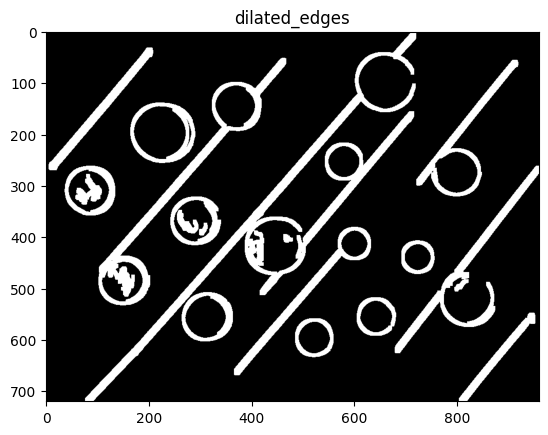

In [5]:
plt.imshow(dilated_edges, cmap='gray')
plt.title('dilated_edges')
plt.show()

In [6]:
# 使用Hough圆变换检测硬币
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 100, param1=50, param2=20, minRadius=0, maxRadius=70)

In [7]:
# Convert the (x, y) coordinates and radius of the circles to integers
rad = np.round(circles[0, :]).astype("int")
rad

array([[220, 196,  54],
       [314, 556,  46],
       [660, 100,  55],
       [ 84, 308,  43],
       [446, 418,  55],
       [798, 274,  44],
       [578, 252,  34],
       [820, 522,  50],
       [372, 146,  44],
       [290, 368,  44],
       [642, 556,  34],
       [600, 412,  29],
       [722, 440,  29],
       [522, 596,  35],
       [144, 492,  38]])

In [8]:
rad = rad[:, 2]
rad

array([54, 46, 55, 43, 55, 44, 34, 50, 44, 44, 34, 29, 29, 35, 38])

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [10]:
# Use Silhouette score to determine the optimal number of clusters
silhouette_scores = []
for i in range(2, 6):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(rad.reshape(-1, 1))
    score = silhouette_score(rad.reshape(-1, 1), kmeans.labels_)
    silhouette_scores.append(score)
    print(f"Number of clusters: {i}, Silhouette score: {score:.2f}")

# Find the optimal number of clusters based on Silhouette score
optimal_clusters = np.argmax(silhouette_scores) + 2
print(f"Optimal number of clusters: {optimal_clusters}")

# Use K-Means algorithm with optimal number of clusters to cluster the rad data
kmeans = KMeans(n_clusters=optimal_clusters)
kmeans.fit(rad.reshape(-1, 1))

# Get the centroid of each cluster
centroids = kmeans.cluster_centers_

# Print the average rad of each cluster
for i in range(len(centroids)):
    avg_rad = np.mean(rad[kmeans.labels_ == i])
    print(f"Cluster {i+1} has {sum(kmeans.labels_ == i)} circles with average rad {avg_rad:.2f}")

Number of clusters: 2, Silhouette score: 0.63
Number of clusters: 3, Silhouette score: 0.69
Number of clusters: 4, Silhouette score: 0.76
Number of clusters: 5, Silhouette score: 0.72
Optimal number of clusters: 4
Cluster 1 has 2 circles with average rad 29.00
Cluster 2 has 5 circles with average rad 44.20
Cluster 3 has 4 circles with average rad 53.50
Cluster 4 has 4 circles with average rad 35.25


In [11]:
# Use K-Means algorithm to cluster the radius data
kmeans = KMeans(n_clusters=4)
kmeans.fit(rad.reshape(-1, 1))

KMeans(n_clusters=4)

In [12]:
# Get the centroid of each cluster
centroids = kmeans.cluster_centers_

# Print the average radius of each cluster
for i in range(len(centroids)):
    avg_radius = np.mean(rad[kmeans.labels_ == i])
    print(f"Cluster {i+1} has {sum(kmeans.labels_ == i)} circles with average radius {avg_radius:.2f}")

Cluster 1 has 5 circles with average radius 44.20
Cluster 2 has 4 circles with average radius 35.25
Cluster 3 has 4 circles with average radius 53.50
Cluster 4 has 2 circles with average radius 29.00


In [13]:
# 统计检测到的硬币数量
num_of_coins = 0
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(img, (x, y), r, (0, 255, 0), 2)
        num_of_coins += 1

检测到的硬币数目： 15


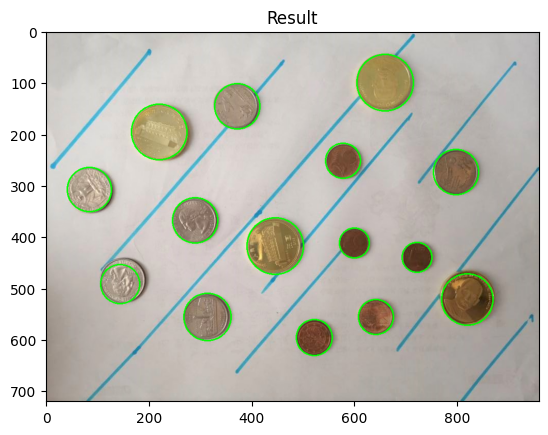

In [14]:
# 打印检测到的硬币数目和线条数
print("检测到的硬币数目：", num_of_coins)

# 使用Matplotlib显示结果
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Result')
plt.show()

In [15]:
# 使用Hough线变换检测线条
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=0, maxLineGap=200)

检测到的线条数目： 9


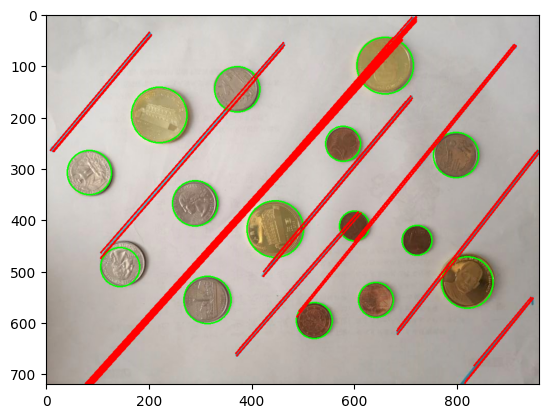

In [21]:
# 应用非最大抑制
def non_max_suppression(boxes, overlapThresh):
    if len(boxes) == 0:
        return []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        suppress = [last]

        for pos in range(last):
            j = idxs[pos]

            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])

            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)

            overlap = float(w * h) / area[j]

            if overlap > overlapThresh:
                suppress.append(pos)

        idxs = np.delete(idxs, suppress)

    return boxes[pick].astype("int")

# 应用非最大抑制来消除重叠的线段
new_lines = []
for line in lines:
    x1, y1, x2, y2 = line[0]
    new_lines.append([x1, y1, x2, y2])

new_lines = np.array(new_lines)
new_lines = non_max_suppression(new_lines, 10)

# 统计线条数目
line_count = len(new_lines)
print("检测到的线条数目：", line_count)

# 将检测到的线绘制到图像上
for line in new_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 4)
# 显示图像
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [22]:
# 使用Hough线变换检测线条
lines = cv2.HoughLinesP(dilated_edges, 1, np.pi/180, 700, minLineLength=0, maxLineGap=200)

In [23]:
# 应用非最大抑制
def non_max_suppression(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        for pos in range(last):
            j = idxs[pos]
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            overlap = float(w * h) / area[j]
            if overlap > overlapThresh:
                suppress.append(pos)
        idxs = np.delete(idxs, suppress)
    return boxes[pick].astype("int")

检测到的线条数目： 9


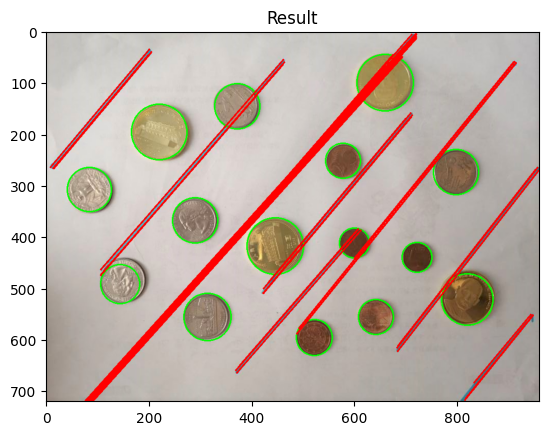

In [24]:
# 应用非最大抑制来消除重叠的线段
new_lines = []
for line in lines:
    x1, y1, x2, y2 = line[0]
    new_lines.append([x1, y1, x2, y2])

new_lines = np.array(new_lines)
new_lines = non_max_suppression(new_lines, 10)

# 统计线条数目
line_count = len(new_lines)
print("检测到的线条数目：", line_count)

# 将检测到的线绘制到图像上
for line in new_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 4)

# 显示图像
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Result")
plt.show()